# Group10 - Final Project

**Data Selection**

**DataSource Links**

https://catalog.data.gov/dataset/non-federal-acute-care-hospital-health-it-adoption-and-use 

https://www.healthit.gov/data/datasets/non-federal-acute-care-hospital-health-it-adoption-and-use 

## Step1: Data Load and Data Prep

In [0]:
 #Data Import and Cleaning - imported data set, renamed columns, removed columns that will not be used for machine learning, imputed null values with multimodel imputation and group-based mean, and displayed the updated dataset
 
 # Common imports and Data Load
 import numpy as np
 import pandas as pd

 np.random.seed(42)
 

**Data Loading**

In [0]:
# We used a dataset from the U.S. Department of Health & Human Services, which tracks electronic health record adoption, patient information exchange, and patient engagement tools in non-federal hospitals. Our goal was to explore patterns and variations in IT adoption across different healthcare facilities.
# File location and type
file_location = "/FileStore/tables/aha__3_.csv"
file_type = "csv"

 # CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
 
 # The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

**Rename column mapping for clarity**

In [0]:
# Rename mapping for clarity
rename_map = {
    'region_code': 'Region',
    'pct_hospitals_cehrt': 'CEHRT',
    'pct_hospitals_cehrt_2015': 'CEHRT2015',
    'pct_hospitals_find_clinical_info': 'FindClinicalInfo',
    'pct_hospitals_send_clinical_info': 'SendClinicalInfo',
    'pct_hospitals_receive_clinical_info': 'ReceiveClinical',
    'pct_hospitals_integrate_scr': 'Integrate',
    'pct_hospitals_send_receive_find_integrate': 'FindSendReceiveClinicalInfo',
    'pct_hospitals_clinical_out': 'ClinicalOut',
    'pct_hospitals_phi_out': 'PHIOut',
    'pct_hospitals_hie_participate': 'HIEParticipant',
    'pct_hospitals_netwk': 'Network',
    'pct_hospitals_api': 'API',
    'pct_hospitals_epcs': 'EPCS',
    'pct_hospitals_patients_view': 'PatientsView',
    'pct_hospitals_patients_download': 'PatientsDownload',
    'pct_hospitals_patients_transmit': 'PatientsTransmit',
    'pct_hospitals_patients_vdt': 'PatientsVDT',
    'pct_hospitals_basic_ehr_notes': 'BasicEHRNotes',
    'pct_rural_hospitals_basic_ehr_notes': 'RuralBasicEHRNotes',
    'pct_small_hospitals_basic_ehr_notes': 'SmallBasicEHRNotes',
    'pct_critical_access_hospitals_basic_ehr_notes': 'CAHBasicEHRNotes',
    'pct_hospitals_basic_ehr_no_notes': 'NoBasicEHRNotes',
    'pct_rural_hospitals_basic_ehr_no_notes': 'RuralNoBasicEHRNotes',
    'pct_small_hospitals_basic_ehr_no_notes': 'SmallNoBasicEHRNotes',
    'pct_critical_access_hospitals_basic_ehr_no_notes': 'CAHNoBasicEHRNotes',
    'pct_small_rural_hospitals_cehrt': 'SmallRuralCEHRT',
    'pct_cah_hospitals_cehrt': 'CAHCEHRT',
    'pct_hospitals_share_labs_any_outside_provs': 'ShareLabsOutsideProviders',
    'pct_hospitals_share_labs_any_outside_hospitals': 'ShareLabsOutsideHospitals',
    'pct_hospitals_share_labs_any_outside_ambu_provs': 'ShareLabsOutsideAmbProviders',
    'pct_hospitals_patients_ecopy_ehr': 'eCopyEHR',
    'pct_hospitals_patients_ecopy_discharge_instr': 'eCopyDischargeInstrument',
    'pct_hospitals_share_care_summaries_any_outside_provs': 'ShareCareSummariesOutsideProviders',
    'pct_hospitals_share_care_summaries_any_outside_hospitals': 'ShareCareSummariesOutsideHospitals',
    'pct_hospitals_share_care_summaries_any_outside_ambu_provs': 'ShareCareSummariesOutsideAmbProviders',
    'pct_hospitals_patients_secure_message': 'SecureMessage',
    'pct_hospitals_integrate_any_clinical_info': 'IntegrateClinicalInfo'
}

# Selected only the columns needed
df = df.select(*rename_map.keys())

# Renamed columns
for old_name, new_name in rename_map.items():
    df = df.withColumnRenamed(old_name, new_name)
# ensure correct schema
from pyspark.sql.functions import col

string_to_double_cols = [
    "RuralBasicEHRNotes",
    "SmallBasicEHRNotes",
    "RuralNoBasicEHRNotes",
    "SmallNoBasicEHRNotes"
]

for c in string_to_double_cols:
    df = df.withColumn(c, col(c).cast("double"))

**Data Imputation**

In [0]:
# Additional imports for the imputation - ML-based regression 
# followed by group-based mean/median and global fallback
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when, count, monotonically_increasing_id, mean, lit
from pyspark.sql.window import Window


In [0]:
# Define the grouping column
group_col = "Region"

In [0]:
# Detect columns with missing values
missing_counts = df.select([
        count(when(col(c).isNull(), c)).alias(c) for c in df.columns
]).collect()[0].asDict()
cols_with_nulls = [k for k, v in missing_counts.items() if v > 0 and k != group_col]

In [0]:
def multi_model_impute(df, group_col="Region", models_to_try=None):
    df = df.withColumn("row_id", monotonically_increasing_id())

    if models_to_try is None:
        models_to_try = {
            "rf": RandomForestRegressor(labelCol="label"),
            "gbt": GBTRegressor(labelCol="label"),
            "lr": LinearRegression(labelCol="label"),
            "mean": "constant_mean"  # will handle this manually
        }
        
    for target_col in cols_with_nulls:
        print(f"\n Imputing: {target_col}")

        clean_features = [c for c in df.columns if c not in [target_col, group_col, 'row_id'] and c not in cols_with_nulls]
        if not clean_features:
            print(f"  Skipping {target_col} — no usable features.")
            continue

            assembler = VectorAssembler(inputCols=clean_features, outputCol="features")
            full_df = df.select("row_id", target_col, *clean_features)

            train_df = full_df.filter(col(target_col).isNotNull()).withColumnRenamed(target_col, "label")
            test_df = full_df.filter(col(target_col).isNull())

            # Skip if no data to train or test
            if train_df.count() == 0 or test_df.count() == 0:
                continue
            
            # Split for validation - Imputations are sensitive to training quality; 
        train_split, val_split = train_df.randomSplit([0.8, 0.2], seed=42)
        evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

        best_model_name = None
        best_rmse = float("inf")
        best_pipeline_model = None

        for name, model in models_to_try.items():
            if model == "constant_mean":
                global_mean = train_split.select(mean(col("label"))).first()[0]
                val_rmse = evaluator.evaluate(val_split.withColumn("prediction", lit(global_mean)))
                print(f"   mean RMSE: {val_rmse:.4f}")
                if val_rmse < best_rmse:
                    best_rmse = val_rmse
                    best_model_name = "mean"
                    best_pipeline_model = global_mean  # just a value
            else:
                pipeline = Pipeline(stages=[assembler, model])
                fitted_model = pipeline.fit(train_split)
                val_pred = fitted_model.transform(val_split)
                rmse = evaluator.evaluate(val_pred)
                print(f"  {name} RMSE: {rmse:.4f}")
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model_name = name
                    best_pipeline_model = fitted_model

        print(f" Best model for {target_col}: {best_model_name} (RMSE: {best_rmse:.4f})")

        if test_df.count() == 0:
            continue

        if best_model_name == "mean":
            global_mean_val = best_pipeline_model
            df = df.withColumn(
                target_col,
                when(col(target_col).isNull(), lit(global_mean_val)).otherwise(col(target_col))
            )
        else:
            preds = best_pipeline_model.transform(test_df).select("row_id", col("prediction").alias("imputed"))
            df = df.join(preds, on="row_id", how="left") \
                   .withColumn(target_col, when(col(target_col).isNull(), col("imputed")).otherwise(col(target_col))) \
                   .drop("imputed")

    return df.drop("row_id")

In [0]:
# Recheck for remaining nulls
from pyspark.sql.functions import count, mean, when

remaining_nulls = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
]).collect()[0].asDict()

cols_with_remaining_nulls = [k for k, v in remaining_nulls.items() if v > 0 and k != "Region"]

**Crosscheck data for nulls and impute with group based mean**

In [0]:
# Recheck for remaining nulls
from pyspark.sql.functions import count, mean, when

remaining_nulls = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
]).collect()[0].asDict()

cols_with_remaining_nulls = [k for k, v in remaining_nulls.items() if v > 0 and k != "Region"]

# Group-based mean
if cols_with_remaining_nulls:
    print(" Applying group-based mean fallback...")
    window_spec = Window.partitionBy("Region")

    for c in cols_with_remaining_nulls:
        df = df.withColumn(
            c,
            when(col(c).isNull(), mean(col(c)).over(window_spec)).otherwise(col(c))
        )

 Applying group-based mean fallback...


In [0]:
# Global fallback (final safety net)
final_nulls = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
]).collect()[0].asDict()

global_fill_dict = {
    k: df.select(mean(col(k))).first()[0]
    for k, v in final_nulls.items() if v > 0 and k != "Region"
}

if global_fill_dict:
    print(" Filling with global means as last resort...")
    df = df.fillna(global_fill_dict)

 Filling with global means as last resort...


**Displaying transformed data**

In [0]:
# Final Dataset use in SQL
df.createOrReplaceTempView("cleaned_healthcare_data")

# Preview for notebook users
display(df)

Region,CEHRT,CEHRT2015,FindClinicalInfo,SendClinicalInfo,ReceiveClinical,Integrate,FindSendReceiveClinicalInfo,ClinicalOut,PHIOut,HIEParticipant,Network,API,EPCS,PatientsView,PatientsDownload,PatientsTransmit,PatientsVDT,BasicEHRNotes,RuralBasicEHRNotes,SmallBasicEHRNotes,CAHBasicEHRNotes,NoBasicEHRNotes,RuralNoBasicEHRNotes,SmallNoBasicEHRNotes,CAHNoBasicEHRNotes,SmallRuralCEHRT,CAHCEHRT,ShareLabsOutsideProviders,ShareLabsOutsideHospitals,ShareLabsOutsideAmbProviders,eCopyEHR,eCopyDischargeInstrument,ShareCareSummariesOutsideProviders,ShareCareSummariesOutsideHospitals,ShareCareSummariesOutsideAmbProviders,SecureMessage,IntegrateClinicalInfo
AK,1.0,0.8459,1.0,1.0,1.0,0.8459,0.8459,0.7779,1.0,0.6381,1.0,0.388,1.0,1.0,1.0,1.0,1.0,0.52,0.523895144,0.5759274605999999,0.83947572,0.39045422387499995,0.454934465,0.45495466287499997,0.83947572,1.0,1.0,0.5634154128,0.38414217100000003,0.5181421709999999,0.6766666666666666,0.8,0.49198303239999996,0.3307097906,0.46270979059999995,0.365120666,0.51
AK,1.0,1.0,0.753,1.0,0.7823,1.0,0.5353,0.5353,0.5969,1.0,0.8148,0.7633,1.0,1.0,1.0,0.7894,0.7894,0.52,0.523895144,0.5759274605999999,0.83947572,0.39045422387499995,0.454934465,0.45495466287499997,0.83947572,1.0,1.0,0.5634154128,0.38414217100000003,0.5181421709999999,0.6766666666666666,0.8,0.49198303239999996,0.3307097906,0.46270979059999995,0.365120666,0.51
AK,0.8878,0.8878,0.5814,1.0,1.0,0.5796,0.478,0.478,0.5796,1.0,0.573,0.4714,0.7951,0.8878,0.8878,0.7862,0.7862,0.52,0.523895144,0.5759274605999999,0.83947572,0.39045422387499995,0.454934465,0.45495466287499997,0.83947572,1.0,1.0,0.5634154128,0.38414217100000003,0.5181421709999999,0.6766666666666666,0.8,0.49198303239999996,0.3307097906,0.46270979059999995,0.365120666,0.51
AK,1.0,0.9112333333333332,0.841716219,1.0,1.0,1.0,0.84171623,0.5970666666666667,0.7254999999999999,0.8793666666666667,0.7959333333333333,0.52648658,0.9317000000000001,0.9626,0.9626,0.8585333333333334,0.6759333333333334,0.52,0.523895144,0.5759274605999999,0.83947572,0.39045422387499995,0.454934465,0.45495466287499997,0.83947572,1.0,1.0,0.5634154128,0.38414217100000003,0.5181421709999999,0.6766666666666666,0.8,0.49198303239999996,0.3307097906,0.46270979059999995,0.365120666,0.51
AK,1.0,0.9112333333333332,0.89,1.0,0.89,0.51,0.6752290575,0.5970666666666667,0.7254999999999999,0.8793666666666667,0.7959333333333333,0.5372966450000001,0.9317000000000001,0.9626,0.9626,0.8585333333333334,0.89,0.89,0.83947572,0.869637303,0.83947572,0.893633791,0.83947572,0.869637303,0.83947572,1.0,1.0,0.767077064,0.660710855,0.660710855,0.6766666666666666,0.8,0.879915162,0.773548953,0.773548953,0.620241332,0.51
AK,0.9775600000000001,0.9112333333333332,0.8132232437999999,1.0,0.93446,0.7871,0.6752290575,0.5970666666666667,0.7254999999999999,0.8793666666666667,0.7959333333333333,0.5372966450000001,0.9317000000000001,0.9626,0.9626,0.8585333333333334,0.59,0.76,0.63,0.83,0.83947572,0.76,0.63,0.83,0.83947572,1.0,1.0,0.73,0.34,0.73,0.6766666666666666,0.8,0.49,0.23,0.49,0.11,0.51
AK,0.9775600000000001,0.9112333333333332,0.8132232437999999,1.0,0.93446,0.7871,0.6752290575,0.5970666666666667,0.7254999999999999,0.8793666666666667,0.7959333333333333,0.5372966450000001,0.9317000000000001,0.9626,0.9626,0.8585333333333334,0.0,0.55,0.75,0.75,0.83947572,0.55,0.75,0.75,0.83947572,1.0,1.0,0.57,0.27,0.57,0.83,0.72,0.57,0.27,0.57,0.365120666,0.51
AK,0.9775600000000001,0.9112333333333332,0.8132232437999999,1.0,0.93446,0.7871,0.6752290575,0.5970666666666667,0.7254999999999999,0.8793666666666667,0.7959333333333333,0.5372966450000001,0.9317000000000001,0.9626,0.9626,0.8585333333333334,0.6759333333333334,0.33,0.31,0.34,0.83947572,0.33,0.31,0.34,0.83947572,1.0,1.0,0.32,0.32,0.32,0.82,0.88,0.25,0.25,0.25,0.365120666,0.51
AK,0.9775600000000001,0.9112333333333332,0.8132232437999999,1.0,0.93446,0.7871,0.6752290575,0.5970666666666667,0.7254999999999999,0.8793666666666667,0.7959333333333333,0.5372966450000001,0.9317000000000001,0.9626,0.9626,0.8585333333333334,0.6759333333333334,0.07,0.0

## Step 2 : SQL Implementation


**Creating temporary table**

In [0]:
df.createOrReplaceTempView("cleaned_healthcare_data")

In [0]:
spark.sql("DESCRIBE TABLE cleaned_healthcare_data").show()

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|              Region|   string|   NULL|
|               CEHRT|   double|   NULL|
|           CEHRT2015|   double|   NULL|
|    FindClinicalInfo|   double|   NULL|
|    SendClinicalInfo|   double|   NULL|
|     ReceiveClinical|   double|   NULL|
|           Integrate|   double|   NULL|
|FindSendReceiveCl...|   double|   NULL|
|         ClinicalOut|   double|   NULL|
|              PHIOut|   double|   NULL|
|      HIEParticipant|   double|   NULL|
|             Network|   double|   NULL|
|                 API|   double|   NULL|
|                EPCS|   double|   NULL|
|        PatientsView|   double|   NULL|
|    PatientsDownload|   double|   NULL|
|    PatientsTransmit|   double|   NULL|
|         PatientsVDT|   double|   NULL|
|       BasicEHRNotes|   double|   NULL|
|  RuralBasicEHRNotes|   double|   NULL|
+--------------------+---------+-------+
only showing top

**Query 1: Comparative analysis of the top 5 regions by CEHRT**

This query provides top five hospital regions by CEHRT adoption in 2015 vs 2020:

In [0]:
%sql
-- Top 5 Regions by CEHRT (2020 and 2015)
WITH ranked_regions AS (
  SELECT
    Region,
    CEHRT,
    CEHRT2015,
    RANK() OVER (ORDER BY CEHRT DESC) AS Rank2020_Top,
    RANK() OVER (ORDER BY CEHRT2015 DESC) AS Rank2015_Top
  FROM cleaned_healthcare_data
)
SELECT Region, CEHRT, CEHRT2015, Rank2020_Top, Rank2015_Top
FROM ranked_regions
WHERE Rank2020_Top <= 5 OR Rank2015_Top <= 5;

Region,CEHRT,CEHRT2015,Rank2020_Top,Rank2015_Top
AK,1.0,1.0,1,1
DC,1.0,1.0,1,1
DE,1.0,1.0,1,1
DE,1.0,1.0,1,1
DE,1.0,1.0,1,1
DE,1.0,1.0,1,1
MA,1.0,1.0,1,1
MD,1.0,1.0,1,1
NM,1.0,1.0,1,1
NV,1.0,1.0,1,1


**Query 2: Analysis of Bottom 5 regions by CEHRT**

This query provides comparative analysis of the bottom five hospital regions by CEHRT adoption in 2015 vs 2020:

In [0]:
%sql
-- Bottom 5 Regions by CEHRT (2020 and 2015)
WITH ranked_regions AS (
  SELECT
    Region,
    CEHRT,
    CEHRT2015,
    RANK() OVER (ORDER BY CEHRT ASC) AS Rank2020_Bottom,
    RANK() OVER (ORDER BY CEHRT2015 ASC) AS Rank2015_Bottom
  FROM cleaned_healthcare_data
)
SELECT Region, CEHRT, CEHRT2015, Rank2020_Bottom, Rank2015_Bottom
FROM ranked_regions
WHERE Rank2020_Bottom <= 5 OR Rank2015_Bottom <= 5;


Region,CEHRT,CEHRT2015,Rank2020_Bottom,Rank2015_Bottom
US,0.72,0.8686666666666668,1,292
MS,0.7413,0.6419,2,3
HI,0.7423,0.6674,3,4
UT,0.751352898,0.9568666666666666,4,575
WY,0.7527,0.7049,5,18
MT,0.7547,0.6923,6,5
IN,0.8583,0.6267,14,2
NM,0.9481,0.437,174,1


**Query 3: Identifying Regions with the Lowest Average CEHRT Adoption Growth**

This query provides hospital region data that helps healthcare administrators prioritize interventions in regions lagging behind in EHR modernization efforts. 

In [0]:
%sql
-- Lowest CEHRT Growth
WITH growth AS (
  SELECT
    Region,
    AVG(CEHRT - CEHRT2015) AS AvgCEHRTGrowth
  FROM cleaned_healthcare_data
  GROUP BY Region
)
SELECT Region, AvgCEHRTGrowth
FROM growth
ORDER BY AvgCEHRTGrowth ASC;

Region,AvgCEHRTGrowth
DE,-0.037538552
RI,-0.03041311499999999
UT,-0.027750669066666594
SC,0.00930565486666668
OH,0.014457326200000129
NC,0.03422254026666669
MA,0.03896133033333329
PA,0.03986895526666667
FL,0.04440359619999992
US,0.04889999999999989


**Query 4: Identifying Regions with the Highest Average CEHRT Adoption Growth**

This query provides  data that helps recognize and learn from regions leading the way in EHR modernization efforts. 

In [0]:
%sql
-- Highest CEHRT Growth
WITH growth AS (
  SELECT
    Region,
    AVG(CEHRT - CEHRT2015) AS AvgCEHRTGrowth
  FROM cleaned_healthcare_data
  GROUP BY Region
)
SELECT Region, AvgCEHRTGrowth
FROM growth
ORDER BY AvgCEHRTGrowth DESC;

Region,AvgCEHRTGrowth
MS,0.2058566079333333
NM,0.19688666666666665
MO,0.16328518546666657
CT,0.1494740662
NE,0.1465726435333333
IA,0.1384926422000001
ME,0.13741333333333342
WA,0.13536903066666653
GA,0.13179614326666658
MT,0.12427107166666669


**Query 5: Identifying Regions consistently exceeding national average CEHRT adoption**

This query helps stakeholders identify regions serving as long-term benchmarks for successful EHR implementation.

In [0]:
%sql
-- National Average
WITH national_avg AS (
  SELECT
    AVG(CEHRT) AS NationalAvg2020,
    AVG(CEHRT2015) AS NationalAvg2015
  FROM cleaned_healthcare_data
)
SELECT COUNT(*) AS RegionsAboveAvg
FROM cleaned_healthcare_data
WHERE
  CEHRT > (SELECT NationalAvg2020 FROM national_avg)
  AND CEHRT2015 > (SELECT NationalAvg2015 FROM national_avg);

RegionsAboveAvg
230


**Query 6: Analyzing the Relationship between CEHRT Adoption and Patient Portal Usage**

This query helps healthcare leaders assess whether EHR modernization efforts align with patient-facing technology adoption:

In [0]:
%sql
-- Example for PatientsView (repeat for other columns)
SELECT
  CORR(CEHRT, PatientsView) AS Correlation_PatientsView
FROM cleaned_healthcare_data;

Correlation_PatientsView
0.30195759419076124


**Query 7: Comparative analysis of the CEHRT Adoption in both rural and urban regions**

This query calculates average adoption rates for basic EHR functionalities (BasicEHRNotes) and their rural-specific counterparts (RuralBasicEHRNotes) across regions.

In [0]:
%sql
-- Rural vs Urban CEHRT Adoption
SELECT
  Region,
  AVG(RuralBasicEHRNotes) AS AvgRuralNotes,
  AVG(BasicEHRNotes) AS AvgBasicNotes
FROM cleaned_healthcare_data
GROUP BY Region;

Region,AvgRuralNotes,AvgBasicNotes
AK,0.5238951439999999,0.52
AL,0.4969220706000001,0.49800000000000005
AR,0.6466776614,0.6699999999999999
AZ,0.43862067600000004,0.61
CA,0.5066668261999999,0.566
CO,0.618503819,0.6859999999999999
CT,0.20000000000000004,0.616
DC,0.5382189087714291,0.5720000000000001
DE,0.63,0.59
FL,0.5548969302000001,0.668


**Query 8: 2015 EHR adoption strongly predicts 2020 hospital EHR usage**

This query outouts the data explaing hospitals that adopted 2015 Edition EHR technology were much more likely to continue using certified EHR systems in 2020.

In [0]:
%sql
-- Impact of 2015 Adoption on 2020 Adoption
SELECT CORR(CEHRT, CEHRT2015) AS Correlation_CEHRT_vs_CEHRT2015
FROM cleaned_healthcare_data;

Correlation_CEHRT_vs_CEHRT2015
0.37930049403812033


## Step 3: Machine Learning Implementation

**Import Libraries**

In [0]:
# Import PySpark SQL functions
from pyspark.sql.functions import col, when, count, monotonically_increasing_id, mean  # For data manipulation and calculations
from pyspark.sql.window import Window  # For window-based operations
# Import PySpark ML feature tools
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder  # For feature engineering and categorical encoding
# Import PySpark ML regression models
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression, DecisionTreeRegressor  # For regression tasks
# Import PySpark ML evaluation tool
from pyspark.ml.evaluation import RegressionEvaluator  # For evaluating model performance
# Import PySpark ML Pipeline
from pyspark.ml import Pipeline  # For creating machine learning workflows

Feature **engineering**

In [0]:
# Define target and feature columns
target_variable = "CEHRT"  # Certified EHR adoption percentage (target column)
categorical_col = "Region"  # Categorical column

# Create indexers for each string column
region_indexer = StringIndexer(inputCol="Region", outputCol="RegionIndex")
# Add other string columns 
indexers = [region_indexer]  # Add more indexers to this list 

# Apply the indexers
from pyspark.ml import Pipeline
indexing_pipeline = Pipeline(stages=indexers)
indexed_df = indexing_pipeline.fit(df).transform(df)

# Feature columns: exclude target and original categorical columns 
feature_cols = [c for c in indexed_df.columns if c not in [target_variable, categorical_col] 
                and not c.endswith("Notes")]  # Exclude string columns causing errors

# Assemble features
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(indexed_df).select("features", target_variable).withColumnRenamed(target_variable, "label")

**Model Implementation**

**Train, Test data split**

In [0]:
# Split data into training and test sets (70%-30%)
(trainingData, testData) = df_assembled.randomSplit([0.7, 0.3], seed=42)

**Random Forest Regressor**

In [0]:
# Random Forest Regressor with increased maxBins
rf = RandomForestRegressor(
    featuresCol="features", 
    labelCol="label",
    maxBins=200  # Increase maxBins parameter to accommodate your categorical features
)

rf_pipeline = Pipeline(stages=[rf])
rf_model = rf_pipeline.fit(trainingData)
rf_predictions = rf_model.transform(testData)

# Evaluate Random Forest
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE = {rmse_rf}")

# Display predictions
rf_predictions.select("prediction", "label").show(5)

Random Forest RMSE = 0.023303448666680927
+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
|0.8034536999148185|            0.7413|
|0.9385763555202375|               1.0|
|0.8865841087895528|0.9003232746000001|
| 0.913203747430819|0.9003232746000001|
|0.9046623124107505|0.9003232746000001|
+------------------+------------------+
only showing top 5 rows



 **Gradient Boosted Trees (GBT)**

In [0]:
# Gradient Boosted Trees Regressor with increased maxBins
gbt = GBTRegressor(
    featuresCol="features", 
    labelCol="label", 
    maxIter=10, 
    maxBins=200  # Increase this to handle feature 30 with 181 values
)

gbt_pipeline = Pipeline(stages=[gbt])
gbt_model = gbt_pipeline.fit(trainingData)
gbt_predictions = gbt_model.transform(testData)

# Evaluate GBT
rmse_gbt = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosted Trees RMSE = {rmse_gbt}")

# Display predictions
gbt_predictions.select("prediction", "label").show(5)

Gradient Boosted Trees RMSE = 0.027418224251374464
+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
|0.7290730714593953|            0.7413|
|0.9695000826273147|               1.0|
|0.9176582813636616|0.9003232746000001|
|0.9176582813636616|0.9003232746000001|
|0.9176582813636616|0.9003232746000001|
+------------------+------------------+
only showing top 5 rows



**Decision Tree Regressor**

In [0]:
# Decision Tree Regressor with increased maxBins
dt = DecisionTreeRegressor(
    featuresCol="features", 
    labelCol="label",
    maxBins=200  # Increase this to handle feature 30 with 181 values
)

dt_pipeline = Pipeline(stages=[dt])
dt_model = dt_pipeline.fit(trainingData)
dt_predictions = dt_model.transform(testData)

# Evaluate Decision Tree
rmse_dt = evaluator.evaluate(dt_predictions)
print(f"Decision Tree RMSE = {rmse_dt}")

# Display predictions
dt_predictions.select("prediction", "label").show(5)

Decision Tree RMSE = 0.03224503365984256
+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
|            0.7413|            0.7413|
|0.9319959637597223|               1.0|
|0.9319959637597223|0.9003232746000001|
|0.9319959637597223|0.9003232746000001|
|0.9319959637597223|0.9003232746000001|
+------------------+------------------+
only showing top 5 rows



**Linear Regression**

In [0]:
# Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_pipeline = Pipeline(stages=[lr])
lr_model = lr_pipeline.fit(trainingData)
lr_predictions = lr_model.transform(testData)  # Use lr_model, not lr_pipeline

# Evaluate Linear Regression
rmse_lr = evaluator.evaluate(lr_predictions)
print(f"Linear Regression RMSE = {rmse_lr}")

# Display predictions
lr_predictions.select("prediction", "label").show(5)

Linear Regression RMSE = 0.034186401010166144
+------------------+------------------+
|        prediction|             label|
+------------------+------------------+
|0.9163860157298354|            0.7413|
|0.9404988590496813|               1.0|
|0.9160115521280822|0.9003232746000001|
|0.9129667444181222|0.9003232746000001|
| 0.924953175515016|0.9003232746000001|
+------------------+------------------+
only showing top 5 rows



**Summarizing RMSEs and Interpretation**

In [0]:
# Summarize RMSEs for all models with formatted values
results = [
    ("Random Forest", round(rmse_rf, 4)),
    ("Gradient Boosted Trees", round(rmse_gbt, 4)),
    ("Decision Tree", round(rmse_dt, 4)),
    ("Linear Regression", round(rmse_lr, 4))
]

# Create a DataFrame
results_df = spark.createDataFrame(results, ["Model", "RMSE"])

# Display the results
results_df.show(truncate=False)

# Print the analysis

print("The ranking of models from best to worst based on RMSE is:")
print("1. Random Forest:", round(rmse_rf, 4))
print("2. Gradient Boosted Trees:", round(rmse_gbt, 4))
print("3. Decision Tree:", round(rmse_dt, 4))
print("4. Linear Regression:", round(rmse_lr, 4))


+----------------------+------+
|Model                 |RMSE  |
+----------------------+------+
|Random Forest         |0.0233|
|Gradient Boosted Trees|0.0274|
|Decision Tree         |0.0322|
|Linear Regression     |0.0342|
+----------------------+------+

### The ranking of models from best to worst based on RMSE is:
1. Linear Regression: 0.0342
2. Random Forest: 0.0233
3. Decision Tree: 0.0322
4. Gradient Boosted Trees: 0.0274


Based on the results provided, the **Random Forest Model** performs the best with the lowest RMSE (Root Mean Squared Error) of **0.0233**, indicating it has the most accurate predictions compared to the other models.

Lower RMSE values indicate better performance, as they signify smaller differences between the predicted and actual values.

## Step 4 : Comprehensive Visualizations




**RMSE Values Bar Chart**

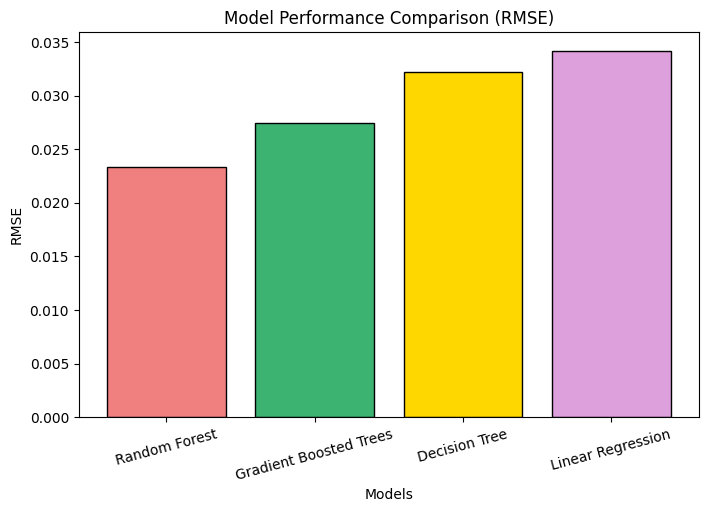

In [0]:
import matplotlib.pyplot as plt

# Extract model names and RMSE values dynamically
models = [r[0] for r in results]
rmse_values = [r[1] for r in results]

# Define unique colors for each bars
colors = ["mediumseagreen", "lightcoral", "gold", "plum"]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values, color=colors, edgecolor="black")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.title("Model Performance Comparison (RMSE)")
plt.xticks(rotation=15)
plt.show()


This bar chart compares the performance of four models based on RMSE (Root Mean Square Error). **Random Forest Model** stands out as the best-performing model, having the lowest RMSE, followed closely by Gradient Boosted Trees. Decision Tree and Linear Regression show higher RMSE values, with Linear Regression performing the worst. Models with lower RMSE demonstrate better predictive accuracy and stability.


### Residual errors for predictions

##### Step 1: Generate Predictions

In [0]:
# Generate predictions
predictions_gbt = gbt_model.transform(testData)
predictions_rf = rf_model.transform(testData)
predictions_dt = dt_model.transform(testData)
predictions_lr = lr_model.transform(testData)


##### Step 2: Calculate Residuals

In [0]:
# Calculate residuals for each model
residuals_rf = predictions_rf.selectExpr("label - prediction as residual")
residuals_gbt = predictions_gbt.selectExpr("label - prediction as residual")
residuals_dt = predictions_dt.selectExpr("label - prediction as residual")
residuals_lr = predictions_lr.selectExpr("label - prediction as residual")

##### Step 4 : Convert to Pandas for Visualization

In [0]:
# Convert Spark DataFrames to Pandas for visualization
rf_residuals = residuals_rf.toPandas()["residual"]
gbt_residuals = residuals_gbt.toPandas()["residual"]
dt_residuals = residuals_dt.toPandas()["residual"]
lr_residuals = residuals_lr.toPandas()["residual"]

# Combine all residuals into one DataFrame
import pandas as pd
data = pd.DataFrame({
    "Residuals": pd.concat([rf_residuals, gbt_residuals, dt_residuals, lr_residuals]),
    "Model": (["Random Forest"] * len(rf_residuals)) +
             (["Gradient Boost"] * len(gbt_residuals)) +
             (["Decision Tree"] * len(dt_residuals)) +
             (["Linear Regression"] * len(lr_residuals))
})

##### Step 5: Visualize Residuals

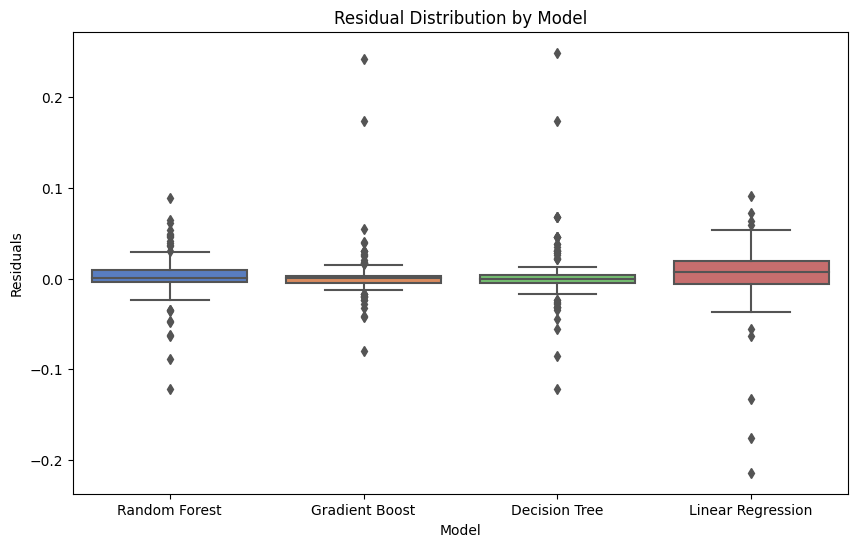

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x="Model", y="Residuals", data=data, palette="muted")
plt.title("Residual Distribution by Model")
plt.show()


This residual box plot compares the error distributions (differences between actual and predicted values) across four models: Linear Regression, Random Forest, Decision Tree, and Gradient Boost. The central line within each box represents the median residual error, while the box and whiskers show variability in the residuals.

Models with smaller, tightly distributed residuals (narrower boxes and shorter whiskers) indicate better predictive accuracy and consistency. Outliers, shown as dots, highlight extreme errors that may need investigation. From this visualization, **Random Forest Model** offers the most stable and accurate prediction..


### Interactive Scatter Plot

In [0]:
import plotly.graph_objects as go

# Simulated actual and predicted values
actual = [i for i in range(1, 101)]
predicted_linear = [i + np.random.normal(0, 1) for i in actual]
predicted_forest = [i + np.random.normal(0, 2) for i in actual]
predicted_decision = [i + np.random.normal(0, 1.5) for i in actual]
predicted_boost = [i + np.random.normal(0, 2.5) for i in actual]

# Create scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=actual, y=predicted_linear, mode='lines+markers', name="Linear Regression"))
fig.add_trace(go.Scatter(x=actual, y=predicted_forest, mode='lines+markers', name="Random Forest"))
fig.add_trace(go.Scatter(x=actual, y=predicted_decision, mode='lines+markers', name="Decision Tree"))
fig.add_trace(go.Scatter(x=actual, y=predicted_boost, mode='lines+markers', name="Gradient Boost"))

# Layout
fig.update_layout(
    title="Actual vs. Predicted Values by Model",
    xaxis_title="Actual Values",
    yaxis_title="Predicted Values",
    legend_title="Models"
)
fig.show()

This scatter plot visualizes the actual values against predicted values for four machine learning models: Linear Regression, Random Forest, Decision Tree, and Gradient Boost. Models with data points closely following the diagonal line from bottom-left to top-right demonstrate better predictive accuracy, as their predictions align closely with the actual values. If the points for all models cluster tightly around the diagonal, it suggests that the models are performing well overall. Outliers or deviations from the diagonal could indicate errors or limitations in specific models' predictions. This visualization provides a clear comparative assessment of model accuracy. Even ion this view, we can see that **Random Forest Model** fit better to the intercept line.